<a href="https://colab.research.google.com/github/JMarsH-MLiS/drone_project/blob/main/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [14]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1) DATA PRE-PROCESSING

a) Load in labels + image file paths

b) combine them into one dataframe

c) EDA - spotted and removed erroneous label (speed = 1.42...)

- `cleaned_df` is the cleaned df with a) b) c) completed

d) convert images to numerical RGB feature maps - ML algorithms only understand numerical data

e) Splitting data into training and validation sets

f) data augmentation applied to training set

### 1a) load in labels + image file paths

In [17]:
labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
#labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [18]:
#image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data' # ben hpc file path (mlis2 cluster)
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [19]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [20]:
imagefilepaths_df.head()

,image_file_paths
image_id,
8,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/8.png
9,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/9.png
14,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/14.png
15,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/15.png
16,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/16.png


### 1b) Combine labels and image file paths into one dataframe

In [21]:
merged_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
merged_df['speed'] = merged_df['speed'].round(6) # to get rid of floating point errors

In [22]:
merged_df.head()

,angle,speed,image_file_paths
image_id,,,
8,0.500,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/8.png
9,0.500,0.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/9.png
14,0.875,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/14.png
15,0.625,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/15.png
16,0.500,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/16.png


In [23]:
merged_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3140,0.875,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) EDA

In [24]:
merged_df.value_counts('speed')

,count
speed,
1.0,3912
0.0,1323


note: imbalance datset

identifying the row with the erroneous speed value

In [25]:
merged_df[merged_df['speed'] == 1.428571]

,angle,speed,image_file_paths
image_id,,,


we want to remove this row

In [26]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,


### 1d) convert images to numerical RGB feature maps

In [27]:
def process_image(image_path, label, resized_shape=(320, 240)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(32)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

lets check and see if what we have done works

In [28]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(32, 320, 240, 3) (32,)


### 1e) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [29]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

In [30]:
print(f"Train size: {train_size}, Test size: {dataset_size - train_size}")

Train size: 131, Test size: 33


### 1f) Data Augmentation applied to training set

- Random Horizontal Flip
- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Vertical Flip



In [31]:
#only performing augmentation on training data as want validation/test data to reflect kaggle test set
seed = (6,9)
train_dataset = train_dataset.map(
      lambda image, label: (tf.image.stateless_random_flip_left_right(image,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_brightness(image, 0.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_contrast(image, 0.8, 1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_hue(image, 0.2, seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_saturation(image, 0.8, 1.2,seed),label)
).map(
      lambda image, label: (tf.image.stateless_random_flip_up_down(image,seed),label)
)

checking to see if whats been done was successful or needs debugging

image shape:  (320, 240, 3)
label: 1


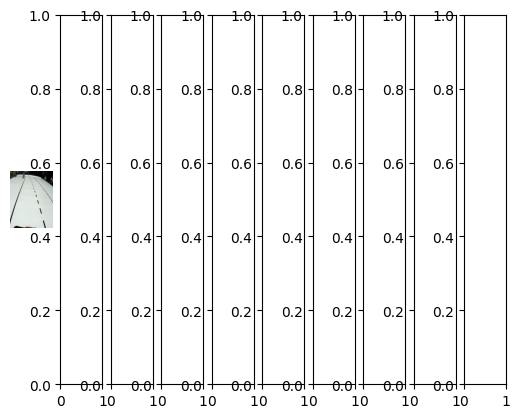

image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 0
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 0
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 1
image shape:  (320, 240, 3)
label: 0
image shape:  (320, 240, 3)
label: 1


In [32]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
        plt.show()

# 2) Model Building

### 2a) MobileNetV2 transfer learning

In [33]:
dropoutrate = 0.2
num_classes = 2
input_shape = (256,256,3)

mbnet =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

<ipython-input-33-2d4f7866841e>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mbnet =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:
with tf.GradientTape() as tape:
  tape.reset() #this resets the gradient tape

In [35]:
LR = 0.001 #learning rate
optimizer = tf.optimizers.Adam(LR) #adam optimiser

@tf.function
def train_step( model, X , Y):
    with tf.GradientTape() as tape:
        pred = model( X )
        current_loss = tf.reduce_mean(tf.losses.categorical_crossentropy( Y,  pred))
    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients( zip( grads , model.trainable_variables) )
    current_accuracy = tf.reduce_mean(tf.metrics.categorical_accuracy(Y, pred))
    return(current_loss, current_accuracy)

In [36]:
niter = 20

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image_batch, label_batch in train_dataset:
      #for image, label in zip(image_batch, label_batch):
        #print(image)
        #print(label)
        #print(image.shape, label.shape)

        loss, acc = train_step(model, image_batch, tf.one_hot(tf.cast(label_batch, dtype=tf.int32), depth=2)) #run training


    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)
'we should probably switch to balanced accuracy as eval method due to unbalanced data'
#commented out validation for now as it prints for each batch not each epoch massively slowwing process
'''
    if it % 50 == 0: #log validation metrics
      for val_image, val_label in validation_dataset:
        val_pred = model(val_image)
        val_int=tf.cast(val_label, dtype=tf.int32)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_int,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_int,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)
'''

ValueError: in user code:

    File "<ipython-input-35-6136d5502028>", line 7, in train_step  *
        pred = model( X )
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInput 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 320, 240, 3)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(32, 320, 240, 3), dtype=float32)
      • training=None
      • mask=None


In [ ]:
'''
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
        plt.show()
'''

In [ ]:
model.save_weights('/content/drive/MyDrive/machine-learning-in-science-ii-2025/car_frozen.weights.h5')

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

In [ ]:
dropoutrate = dropoutrate
num_classes = num_classes
input_shape = input_shape

mbnet =  tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build()

mbnet.trainable = False

model.summary() # print the model

In [ ]:
model.load_weights('/content/drive/MyDrive/machine-learning-in-science-ii-2025/car_frozen.weights.h5')

In [ ]:
mbnet.trainable = True
model.summary()

In [ ]:
LR = 0.0001
optimizer = tf.optimizers.Adam(LR) #adam optimiser


In [ ]:
niter = 20

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    for image, label in train_dataset:
        loss, acc = train_step(model, image_batch, tf.one_hot(tf.cast(label_batch, dtype=tf.int32), depth=2))

    if it % 10 == 0: #log training metrics
      tf.print('iter: ',it, ', loss: {:.3f}, acc: {:.3f}'.format(loss, acc))
      tloss.append(loss)
      tacc.append(acc)
'''
    if it % 50 == 0: #log validation metrics
      for val_image, val_label in valid:
        val_pred = model(val_image)
        val_loss = tf.reduce_mean(tf.losses.categorical_crossentropy(tf.one_hot(val_label,depth=2) , val_pred))
        val_acc = tf.reduce_mean(tf.metrics.categorical_accuracy(tf.one_hot(val_label,depth=2) , val_pred))
        tf.print('iter: ',it, ', validation loss: {:.3f}, validation acc: {:.3f}'.format(val_loss, val_acc))
        vloss.append(val_loss)
        vacc.append(val_acc)
'''

In [ ]:
model.save_weights('/content/drive/MyDrive/machine-learning-in-science-ii-2025/car_unfrozen.weights.h5')

In [ ]:
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/test_data/test_data'
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

In [ ]:
def process_image_no_label(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, (128, 128))  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image
test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
predictions = model.predict(test_dataset)

In [ ]:
predictions_df.head()

In [ ]:
predictions_df[[0,1]] > 0.5

In [ ]:
predictions_df = pd.DataFrame(predictions)

In [ ]:
predictions_df[predictions_df[[0,1]] > 0.5] = 1
predictions_df[predictions_df[[0,1]] < 0.5] = 0

In [ ]:
predictions_df[0]

In [ ]:
predictions_df[0].value_counts()

# Using Grad CAM

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def grad_cam(model, image, class_idx, last_conv_layer_name="Conv_1"):
    """
    Compute Grad-CAM heatmap for an image.

    Parameters:
    - model: Trained Keras model.
    - image: Preprocessed image (normalized, resized).
    - class_idx: Index of the target class for which Grad-CAM is computed.
    - last_conv_layer_name: Name of the last convolutional layer in MobileNetV2.

    Returns:
    - Heatmap overlayed on the original image.
    """
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize to [0,1]

    return heatmap.numpy()

def overlay_heatmap(image, heatmap, alpha=0.4):
    """
    Overlay heatmap on the original image.

    Parameters:
    - image: Original image.
    - heatmap: Heatmap generated from Grad-CAM.
    - alpha: Transparency factor for the overlay.

    Returns:
    - Image with heatmap overlay.
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return superimposed_image

# Select an image from validation set for visualization
for image_batch, label_batch in validation_dataset.take(1):
    sample_image = image_batch[0].numpy()
    sample_label = label_batch[0].numpy()
    break

# Generate heatmap
heatmap = grad_cam(model, sample_image, class_idx=int(sample_label))

# Overlay heatmap on the image
superimposed_image = overlay_heatmap((sample_image * 255).astype("uint8"), heatmap)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(superimposed_image)
plt.title("Overlayed Heatmap")
plt.axis("off")

plt.show()


AttributeError: The layer sequential has never been called and thus has no defined input.